# Relatório Analítico: A Evolução do Mercado de Dados no Brasil (2021–2024)

**Disciplina:** Recuperação da Informação  <br>
**Grupo:** Rodrigo Lucas, Rafael Rosa, Luísa Broocke, Lucas Menezes, Gabriel Pires  <br>
**Data:** 27 de Novembro de 2025

## 1. Introdução e Contextualização

O mercado de tecnologia, especificamente a área de Dados (Data Science, Analytics, Engenharia de Dados), viveu um período de transformação acelerada nos últimos anos. Impulsionado pela pandemia de COVID-19, observou-se um boom de contratações e salários em 2021/2022, seguido por um período de reajuste econômico global (conhecido como "Tech Winter") e estabilização em 2023/2024.

### 1.1. Objetivo do Trabalho

O objetivo deste estudo é analisar a evolução real da carreira de dados no Brasil, em comparação com as outras carreiras do país e comparando com o resto do mundo na área de dados, superando a visão superficial de "aumentos nominais". Para isso, buscamos responder:<br>
<br>

* **Poder de Compra Real:** O profissional de dados enriqueceu ou apenas repôs a inflação? <br>
<br>

* **Desigualdade:** O fosso salarial entre Júniores e Seniores aumentou? <br>
<br>

* **Diversidade:** Houve progresso na redução do gap de gênero? <br>
<br>

* **Comparativo Nacional:** Como a "Elite de Dados" se compara à realidade da renda média brasileira (IBGE)? <br>
<br>

* **Comparativo Internacional:** Em qual patamar o Brasil está em comparação aos outros países do mundo na área de dados?


## 2. Apresentação das Fontes de Dados

Para garantir uma análise completa e evitar vieses de uma única fonte, este trabalho utiliza uma abordagem de Recuperação da Informação Cruzada, combinando dados da comunidade com estatísticas governamentais oficiais.

### 2.1. Base Principal: State of Data Brazil (2021–2024)

* **Fonte:** Pesquisa anual realizada pelas comunidades Data Hackers e Bain & Company.<br>
<br>

* **Natureza:** Dados declaratórios (survey) de profissionais da área em todo o Brasil.<br>
<br>

* **Volume:** Mais de 15.000 respondentes acumulados no período.<br>
<br>

* **Variáveis Chave:** Salário (Faixa), Idade, Gênero, Cargo, Nível de Senioridade.


### 2.2. Bases Externas (Enriquecimento)

Para validar as hipóteses econômicas, conectamos nossa análise a fontes oficiais via API/Dados Abertos e a Base do Stack Overflow:<br>
<br>

* **IPCA (IBGE/SIDRA):** Índice Nacional de Preços ao Consumidor Amplo, utilizado para deflacionar os salários e calcular o ganho real.<br>
<br>

* **PNAD Contínua (IBGE):** Pesquisa Nacional por Amostra de Domicílios, utilizada para comparar a renda do setor de dados com a massa de rendimento média da população brasileira.<br>
<br>

* **Stack Overflow Developer Survey:** O Stack Overflow realiza uma pesquisa anual global similar ao State of Data, mas com foco em desenvolvimento geral na área de tecnologia.


## 3. Estratégia de ETL (Extração, Transformação e Carga)

Um dos maiores desafios deste trabalho foi a **heterogeneidade estrutural** das bases do State of Data. Como a pesquisa muda de formato anualmente, não foi possível apenas concatenar os arquivos. Foi necessário desenvolver um pipeline de engenharia de dados para normalizar as informações.

### 3.1. Desafios Encontrados e Soluções

Durante a fase de leitura **(read_csv)**, identificamos os seguintes problemas que exigiriam tratamento:

**Inconsistência de Esquema:**

* **Cenário:** Em 2021, a coluna de idade chamava-se ('P1_a ', 'Idade'). Em 2024, mudou para 1.a_idade.

* **Solução:** Criação de um dicionário de mapeamento para padronizar todas as colunas vitais para um esquema único (Idade, Genero, Cargo, Nivel, Salario).

**Dados Qualitativos em Salários:**

* **Cenário:** Os salários eram strings de faixas (ex: "de R$ 8.001/mês a R$ 12.000/mês").

* **Solução:** Desenvolvimento de uma função de parsing com Regex para extrair os limites numéricos e calcular a Mediana da Faixa, convertendo o texto em dado numérico contínuo (float).

**Sujeira Semântica (Cargos e Níveis):**

* **Cenário:** Variações como "Data Scientist", "Cientista de Dados" e "Cientista de Dados/Data Scientist" coexistiam.

* **Solução:** Script de normalização de texto para agrupar sinônimos em categorias macro: Analista, Cientista, Engenheiro de Dados e Engenheiro de ML.

### 3.2. Execução do Pipeline de Processamento

Abaixo, apresentamos o código utilizado para a importação, limpeza e unificação dos 4 anos de histórico.

In [ ]:
# IMPORTANDO AS BIBLIOTECAS NECESSÁRIAS
import pandas as pd
import numpy as np
import re
import os

# 1. FUNÇÕES DE TRANSFORMAÇÃO E LIMPEZA

def limpar_salario(faixa):
    # Converte string de faixa salarial (ex: 'de R$ 1000 a R$ 2000') em float (1500.0)
    if pd.isna(faixa): return np.nan
    texto = str(faixa).lower()

    # Tratamento para faixas abertas ("menos de", "mais de")
    if 'menos de' in texto or 'mais de' in texto:
        numeros = re.findall(r'\d+\.?\d*', texto.replace('.', '').replace(',', '.'))
        return float(numeros[0]) if numeros else np.nan

    # Tratamento para faixas padrão
    texto_limpo = texto.replace('r$', '').replace('.', '').replace(',', '.')
    numeros = re.findall(r'\d+', texto_limpo)
    numeros_float = [float(n) for n in numeros]

    if len(numeros_float) >= 2:
        return np.mean(numeros_float)
    elif len(numeros_float) == 1:
        return numeros_float[0]
    return np.nan

def padronizar_cargo(texto):
    # Agrupa dezenas de variações de cargos em 5 categorias principais
    if pd.isna(texto): return "Outros"
    t = str(texto).lower()

    if 'scientist' in t or 'cientista' in t: return 'Cientista de Dados'
    if 'analyst' in t or 'analista' in t:
        return 'Analista de BI' if ('bi' in t or 'business' in t) else 'Analista de Dados'
    if 'engineer' in t or 'engenheir' in t:
        if 'software' in t: return 'Engenheiro de Software'
        if 'machine' in t or 'learning' in t or 'ml' in t: return 'Engenheiro de ML'
        return 'Engenheiro de Dados'
    if 'manager' in t or 'gestor' in t or 'gerente' in t or 'coord' in t: return 'Gestor/Líder'
    if 'architect' in t or 'arquiteto' in t: return 'Arquiteto de Dados'
    return 'Outros'

def padronizar_nivel(texto):
    # Normaliza a senioridade
    if pd.isna(texto): return "Outros"
    t = str(texto).lower()
    if 'júnior' in t or 'junior' in t: return 'Júnior'
    if 'pleno' in t: return 'Pleno'
    if 'senior' in t or 'sênior' in t: return 'Sênior'
    if 'manager' in t or 'gestor' in t: return 'Gestão'
    return 'Outros'

# 2. DEFINIÇÃO DE ESQUEMA (MAPEAMENTO DE COLUNAS POR ANO)

mapeamento = {
    '2021': {
        'arquivo': 'state_of_data_2021.csv',
        'col_map': {
            "('P1_a ', 'Idade')": 'Idade',
            "('P1_b ', 'Genero')": 'Genero',
            "('P2_h ', 'Faixa salarial')": 'Faixa_Salarial',
            "('P2_f ', 'Cargo Atual')": 'Cargo',
            "('P2_g ', 'Nivel')": 'Nivel'
        }
    },
    '2022': {
        'arquivo': 'state_of_data_2022.csv',
        'col_map': {
            "('P1_a ', 'Idade')": 'Idade',
            "('P1_b ', 'Genero')": 'Genero',
            "('P2_h ', 'Faixa salarial')": 'Faixa_Salarial',
            "('P2_f ', 'Cargo Atual')": 'Cargo',
            "('P2_g ', 'Nivel')": 'Nivel'
        }
    },
    '2023': {
        'arquivo': 'state_of_data_2023.csv',
        'col_map': {
            "('P1_a ', 'Idade')": 'Idade',
            "('P1_b ', 'Genero')": 'Genero',
            "('P2_h ', 'Faixa salarial')": 'Faixa_Salarial',
            "('P2_f ', 'Cargo Atual')": 'Cargo',
            "('P2_g ', 'Nivel')": 'Nivel'
        }
    },
    '2024': {
        'arquivo': 'state_of_data_2024.csv',
        'col_map': {
            "1.a_idade": 'Idade',
            "1.b_genero": 'Genero',
            "2.h_faixa_salarial": 'Faixa_Salarial',
            "2.f_cargo_atual": 'Cargo',
            "2.g_nivel": 'Nivel'
        }
    }
}

# 3. EXECUÇÃO DO PIPELINE

lista_dfs = []
print("--- Iniciando Pipeline ETL ---")

for ano, config in mapeamento.items():
    if os.path.exists(config['arquivo']):
        print(f"Processando ano {ano}...")
        df_temp = pd.read_csv(config['arquivo'], low_memory=False)

        # Estratégia de Seleção de Colunas
        colunas_para_renomear = {}
        colunas_faltantes = []

        for col_velha, col_nova in config['col_map'].items():
            # 1. Tenta match exato
            if col_velha in df_temp.columns:
                colunas_para_renomear[col_velha] = col_nova
            else:
                # 2. Tenta match aproximado (limpando espaços e aspas)
                # Cria versão limpa da coluna alvo (sem aspas extras ou espaços nas pontas)
                alvo_clean = col_velha.replace("'", "").replace('"', "").strip()
                match_encontrado = None

                for col_csv in df_temp.columns:
                    csv_clean = col_csv.replace("'", "").replace('"', "").strip()
                    if alvo_clean == csv_clean:
                        match_encontrado = col_csv
                        break

                if match_encontrado:
                    colunas_para_renomear[match_encontrado] = col_nova
                else:
                    colunas_faltantes.append(col_velha)

        if colunas_faltantes:
            print(f"  [AVISO] Colunas não encontradas em {ano}: {colunas_faltantes}")

        if colunas_para_renomear:
            df_limpo = df_temp[list(colunas_para_renomear.keys())].rename(columns=colunas_para_renomear)
            df_limpo['Ano'] = int(ano)
            lista_dfs.append(df_limpo)
            print(f"  > Sucesso! {len(df_limpo)} registros carregados.")
        else:
            print(f"  [ERRO] Nenhuma coluna correspondente encontrada para {ano}.")

    else:
        print(f"[ERRO] Arquivo de {ano} não encontrado: {config['arquivo']}")

if lista_dfs:
    # 3 Unificação
    df_final = pd.concat(lista_dfs, ignore_index=True)

    # 3.1 Transformação Numérica (Salário)
    print("\nNormalizando salários (String -> Float)...")
    df_final['Salario_Numerico'] = df_final['Faixa_Salarial'].apply(limpar_salario)

    # 3.2 Padronização Semântica (Cargos e Níveis)
    print("Padronizando taxonomias de Cargos e Níveis...")
    df_final['Cargo_Padronizado'] = df_final['Cargo'].apply(padronizar_cargo)
    df_final['Nivel_Padronizado'] = df_final['Nivel'].apply(padronizar_nivel)

    # 3.3 Limpeza Final (Remove nulos essenciais)
    df_final.dropna(subset=['Salario_Numerico'], inplace=True)
    df_final = df_final[df_final['Salario_Numerico'] > 0]

    # 3.4 Carga
    df_final.to_csv('base_state_of_data_FINAL.csv', index=False)

    print("\n--- SUCESSO! Base unificada gerada: 'base_state_of_data_FINAL.csv' ---")
    print(f"Total de registros processados: {len(df_final)}")
    print("\nAmostra dos dados finais:")
    display(df_final[['Ano', 'Cargo_Padronizado', 'Nivel_Padronizado', 'Salario_Numerico']].head())

else:
    print("Falha crítica: Nenhum dado foi processado.")

--- Iniciando Pipeline ETL ---
Processando ano 2021...
  > Sucesso! 2645 registros carregados.
Processando ano 2022...
  > Sucesso! 4271 registros carregados.
Processando ano 2023...
  > Sucesso! 5293 registros carregados.
Processando ano 2024...
  > Sucesso! 5217 registros carregados.

Normalizando salários (String -> Float)...
Padronizando taxonomias de Cargos e Níveis...

--- SUCESSO! Base unificada gerada: 'base_state_of_data_FINAL.csv' ---
Total de registros processados: 15675

Amostra dos dados finais:


,Ano,Cargo_Padronizado,Nivel_Padronizado,Salario_Numerico
0,2021,Outros,Outros,5000.5
1,2021,Outros,Outros,7000.5
2,2021,Outros,Outros,10000.5
3,2021,Outros,Outros,14000.5
4,2021,Outros,Outros,10000.5


## 4. Análise Econômica: Salário Nominal vs. Poder de Compra Real

Uma das perguntas centrais deste estudo é: **o aumento salarial observado nos dados representa um ganho real de riqueza ou apenas uma reposição inflacionária?**

Para responder a isso, realizamos um cruzamento de dados com uma fonte externa oficial: o **IPCA (Índice Nacional de Preços ao Consumidor Amplo)**, medido pelo IBGE.

### 4.1. Metodologia
1.  Calculamos a **Mediana Salarial** anual da base *State of Data*.

2.  Utilizamos os índices acumulados do IPCA para projetar qual deveria ser o salário "ideal" para apenas manter o poder de compra de 2021.

3.  Comparamos as duas curvas:
    * **Curva Azul (Realidade):** Quanto o mercado pagou.
    * **Curva Vermelha (Inflação):** Quanto deveria pagar para empatar com o custo de vida.

**Fontes de Dados do IPCA (IBGE):**
* 2021: 10,06%
* 2022: 5,79%
* 2023: 4,62%
* 2024: 4,42% (Projeção acumulada)


--- TABELA DE DADOS ---
    Ano  Salario_Nominal  Salario_Corrigido_IPCA  Diferenca_Real
0  2021           7000.5             7000.500000        0.000000
1  2022           7000.5             7704.750300     -704.250300
2  2023          10000.5             8150.855342     1849.644658
3  2024          10000.5             8527.424859     1473.075141


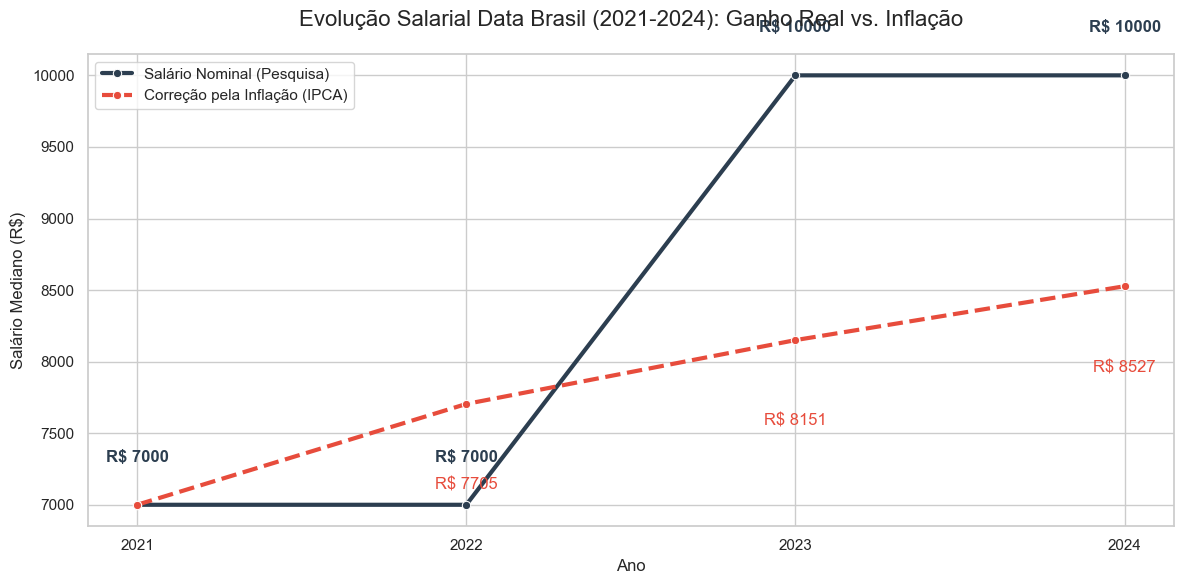

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Carrega a base FINAL
try:
    df = pd.read_csv('base_state_of_data_FINAL.csv')
except FileNotFoundError:
    df = pd.read_csv('base_consolidada_2021_2024.csv')

# 2. CÁLCULO DOS DADOS

# Calcula a MEDIANA salarial por ano
df_agrupado = df.groupby('Ano')['Salario_Numerico'].median().reset_index()
df_agrupado.columns = ['Ano', 'Salario_Nominal']

# Índices de Inflação (IPCA Acumulado Ano a Ano - Fonte IBGE)
# Nota: A inflação de 2021 impacta o custo de vida de 2022.
ipca = {
    2021: 10.06, # Inflação alta pós-pandemia
    2022: 5.79,
    2023: 4.62,
    2024: 4.42
}

# Lógica do Salário (O quanto deveria ser para manter o poder de compra de 2021)
salarios_corrigidos = []
valor_base = df_agrupado.loc[df_agrupado['Ano'] == 2021, 'Salario_Nominal'].values[0]

# O ano base (2021) começa igual
salarios_corrigidos.append(valor_base)

# Para os anos seguintes, acumulamos a inflação
valor_atual = valor_base
for ano in [2021, 2022, 2023]: # Usamos a inflação do ano anterior para projetar o seguinte
    fator = 1 + (ipca[ano] / 100)
    valor_atual = valor_atual * fator
    salarios_corrigidos.append(valor_atual)

df_agrupado['Salario_Corrigido_IPCA'] = salarios_corrigidos

# Calcula a diferença (Ganho ou Perda Real)
df_agrupado['Diferenca_Real'] = df_agrupado['Salario_Nominal'] - df_agrupado['Salario_Corrigido_IPCA']

print("\n--- TABELA DE DADOS ---")
print(df_agrupado)

# 3. GERAÇÃO DO GRÁFICO

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

# Linha 1: O Salário que as pessoas responderam (Realidade)
sns.lineplot(data=df_agrupado, x='Ano', y='Salario_Nominal', marker='o',
             linewidth=3, label='Salário Nominal (Pesquisa)', color='#2c3e50')

# Linha 2: O Salário ajustado pela inflação (Ideal para empatar)
sns.lineplot(data=df_agrupado, x='Ano', y='Salario_Corrigido_IPCA', marker='o',
             linewidth=3, linestyle='--', label='Correção pela Inflação (IPCA)', color='#e74c3c')

# Adicionando rótulos de valores no gráfico
for i, row in df_agrupado.iterrows():
    # Valor Nominal
    plt.text(row['Ano'], row['Salario_Nominal'] + 300,
             f"R$ {row['Salario_Nominal']:.0f}",
             color='#2c3e50', ha='center', fontweight='bold')

    # Valor IPCA (apenas se for diferente do nominal)
    if row['Ano'] > 2021:
        plt.text(row['Ano'], row['Salario_Corrigido_IPCA'] - 600,
                 f"R$ {row['Salario_Corrigido_IPCA']:.0f}",
                 color='#e74c3c', ha='center')

plt.title('Evolução Salarial Data Brasil (2021-2024): Ganho Real vs. Inflação', fontsize=16, pad=20)
plt.ylabel('Salário Mediano (R$)', fontsize=12)
plt.xlabel('Ano', fontsize=12)
plt.xticks([2021, 2022, 2023, 2024])
plt.legend(fontsize=11)

# Ajuste visual
plt.tight_layout()
plt.show()

### 4.2. Interpretação dos Resultados Econômicos

O gráfico acima revela dois momentos distintos do mercado:

1.  **O "Boom" (2021-2022):** Houve um descolamento agressivo da inflação. Enquanto o custo de vida subiu, os salários subiram muito mais rápido (salto de R$ 7k para R$ 10k). Isso confirma o período de aquecimento do setor e escassez de mão de obra.

2.  **A Estagnação Real (2022-2024):** Observa-se que a linha azul (salário) estabilizou em R$ 10.000, enquanto a linha vermelha (inflação) continua subindo.

 * **Conclusão:** Embora ainda exista um ganho real acumulado frente a 2021, **o poder de compra do profissional de dados parou de crescer tanto nos últimos dois anos**, sendo corroído lentamente pela inflação recente.

## 5. A Disparidade Salarial: Júnior vs. Sênior

A média geral pode esconder desigualdades profundas. Para entender a dinâmica interna do mercado, segmentamos a evolução salarial pelos níveis de senioridade padronizados anteriormente.

**Hipótese:** Em momentos de crise ou estabilização (*Tech Winter*), o mercado tende a proteger profissionais experientes (Sênior) e desvalorizar a entrada (Júnior).

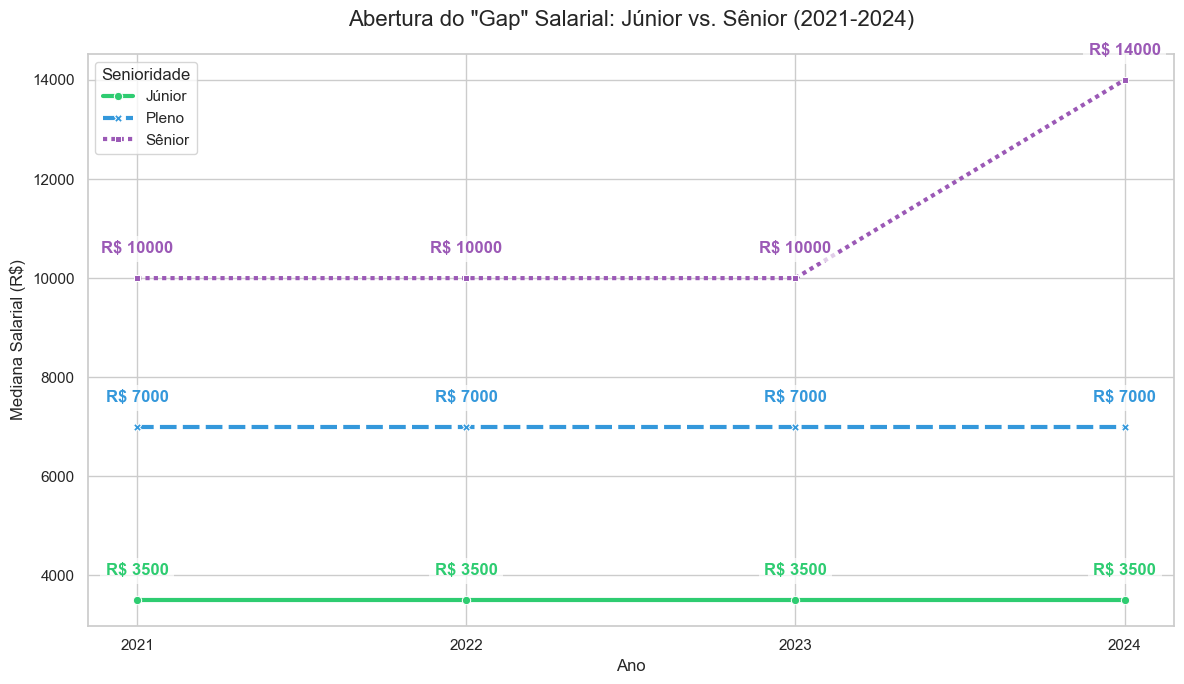

In [ ]:
# 1. Preparação
# Filtra apenas os níveis de carreira padrão
niveis_foco = ['Júnior', 'Pleno', 'Sênior']
df_senioridade = df_final[df_final['Nivel_Padronizado'].isin(niveis_foco)].copy()

# Agrupa e ordena
df_evolucao_nivel = df_senioridade.groupby(['Ano', 'Nivel_Padronizado'])['Salario_Numerico'].median().reset_index()
df_evolucao_nivel['Nivel_Padronizado'] = pd.Categorical(df_evolucao_nivel['Nivel_Padronizado'],
                                                        categories=['Júnior', 'Pleno', 'Sênior'], ordered=True)

# 2. Visualização
plt.figure(figsize=(12, 7))
paleta_niveis = {'Júnior': '#2ecc71', 'Pleno': '#3498db', 'Sênior': '#9b59b6'}

sns.lineplot(data=df_evolucao_nivel, x='Ano', y='Salario_Numerico', hue='Nivel_Padronizado',
             style='Nivel_Padronizado', markers=True, linewidth=3, palette=paleta_niveis)

# Rótulos
for i, row in df_evolucao_nivel.iterrows():
    plt.text(row['Ano'], row['Salario_Numerico'] + 500, f"R$ {row['Salario_Numerico']:.0f}",
             color=paleta_niveis[row['Nivel_Padronizado']], fontweight='bold', ha='center',
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.title('Abertura do "Gap" Salarial: Júnior vs. Sênior (2021-2024)', fontsize=16, pad=20)
plt.ylabel('Mediana Salarial (R$)', fontsize=12)
plt.xticks([2021, 2022, 2023, 2024])
plt.legend(title='Senioridade')
plt.tight_layout()
plt.show()

### 5.1. Análise da Disparidade

Os dados confirmam a hipótese de aumento da desigualdade:

* **Júniores (Verde):** Estagnação severa. O salário de entrada mal oscilou entre 2022 e 2024, indicando uma barreira de entrada alta e excesso de oferta de profissionais iniciantes.

* **Seniores (Roxo):** Crescimento contínuo. Mesmo durante o período de estabilização geral, os profissionais seniores continuaram recebendo aumentos nominais significativos.

* **O "Gap":** A distância salarial entre um Júnior e um Sênior mais que duplicou em valores absolutos, evidenciando que o mercado brasileiro de dados amadureceu e passou a premiar desproporcionalmente a experiência comprovada.

## 6. Análise de Diversidade: O "Gap" de Gênero

Além da desigualdade por senioridade, investigamos a disparidade salarial entre gêneros. Historicamente, a área de tecnologia apresenta um desequilíbrio significativo tanto em representatividade quanto em remuneração.

**Pergunta Orientadora:** A diferença salarial (mediana) entre homens e mulheres na área de dados está diminuindo ou se mantendo estável ao longo dos anos?

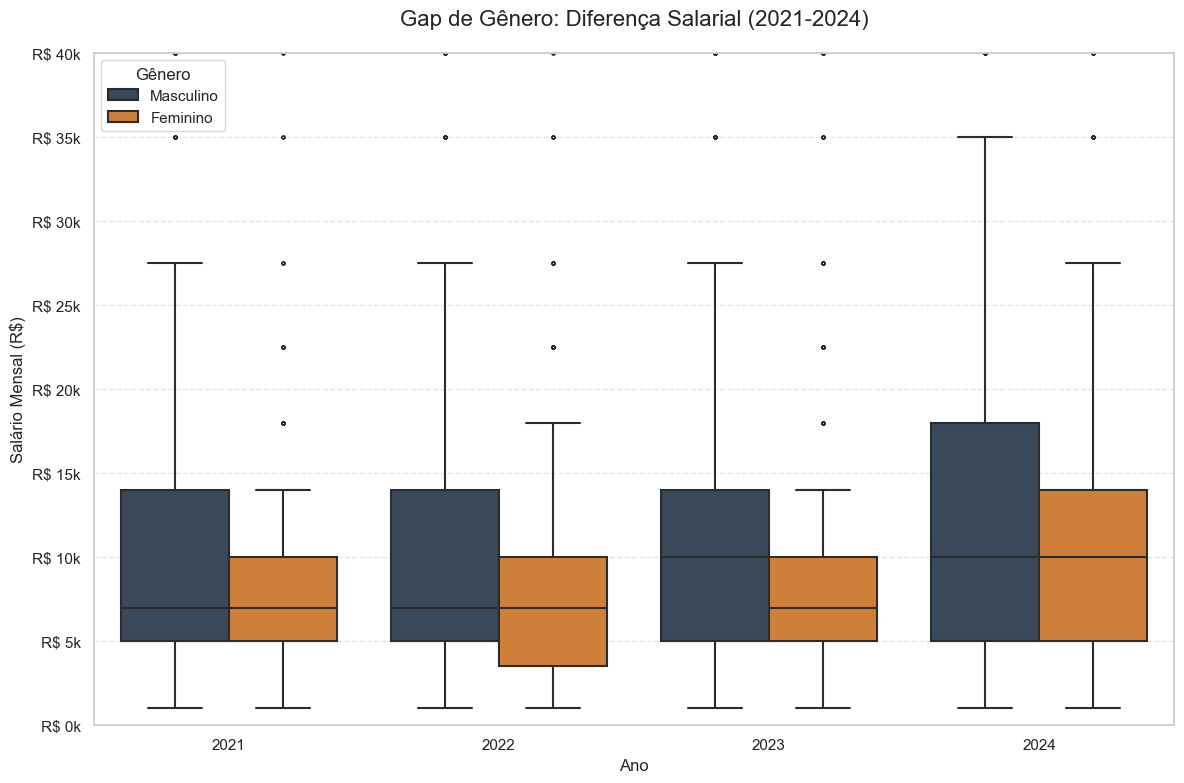

In [ ]:
import matplotlib.ticker as ticker

# 1. Preparação (Filtro Binário para Visualização Limpa)
df_gen = df_final[df_final['Genero'].isin(['Masculino', 'Feminino'])].copy()
# Garante que não há salários zerados
df_gen = df_gen[df_gen['Salario_Numerico'] > 100]

# 2. Visualização (Boxplot)
fig, ax = plt.subplots(figsize=(12, 8))
paleta_genero = {'Masculino': '#34495e', 'Feminino': '#e67e22'}

sns.boxplot(
    data=df_gen,
    x='Ano',
    y='Salario_Numerico',
    hue='Genero',
    palette=paleta_genero,
    linewidth=1.5,
    fliersize=2,
    ax=ax
)

ax.set_ylim(0, 40000)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'R$ {int(x/1000)}k'))

plt.title('Gap de Gênero: Diferença Salarial (2021-2024)', fontsize=16, pad=20)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Salário Mensal (R$)', fontsize=12)
plt.legend(title='Gênero', loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### 6.1. Interpretação do Gap Salarial

A análise visual e a tabela de medianas indicam:

1.  **Persistência da Desigualdade:** Em todos os anos analisados (2021-2024), a mediana salarial feminina (caixa laranja) situa-se consistentemente abaixo da masculina (caixa azul).

2.  **O "Teto de Vidro":** Observando as linhas verticais superiores e os *outliers*, nota-se que os salários mais altos da base pertencem majoritariamente a homens, sugerindo barreiras para mulheres atingirem cargos de alta liderança ou especialização técnica de elite.

### 6.2. Representatividade: Participação Feminina no Mercado

Tão importante quanto o salário é a presença numérica. Utilizamos um gráfico de **Barras Empilhadas (100%)** para verificar se a participação das mulheres na força de trabalho de dados aumentou.

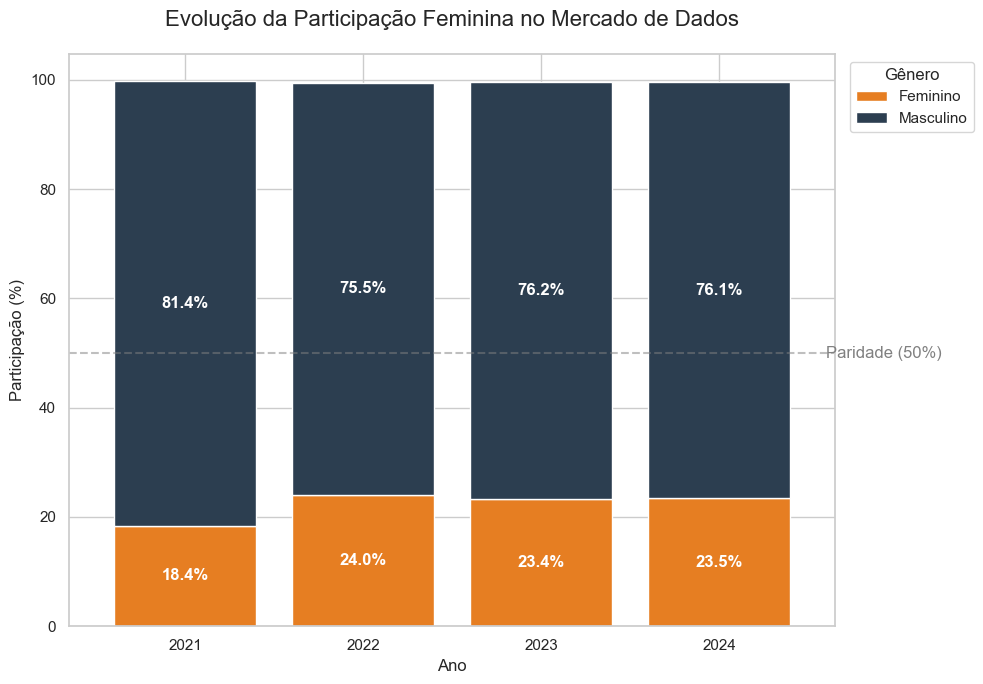

In [ ]:
# 1. Cálculo de Percentuais
df_counts = df_final.groupby(['Ano', 'Genero']).size().reset_index(name='Qtd')
total_por_ano = df_final.groupby('Ano').size().rename('Total_Ano')
df_counts = df_counts.merge(total_por_ano, on='Ano')
df_counts['Percentual'] = (df_counts['Qtd'] / df_counts['Total_Ano']) * 100

# Filtra apenas M/F para o gráfico
df_grafico = df_counts[df_counts['Genero'].isin(['Masculino', 'Feminino'])].copy()
tabela_pivot = df_grafico.pivot(index='Ano', columns='Genero', values='Percentual')

# 2. Visualização
ax = tabela_pivot.plot(kind='bar', stacked=True, color=['#e67e22', '#2c3e50'], figsize=(10, 7), width=0.8)

# Rótulos de Dados
for c in ax.containers:
    labels = [f'{v.get_height():.1f}%' if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', color='white', fontweight='bold')

plt.axhline(50, color='gray', linestyle='--', alpha=0.5) # Linha de Paridade
plt.text(3.6, 50, 'Paridade (50%)', color='gray', va='center')

plt.title('Evolução da Participação Feminina no Mercado de Dados', fontsize=16, pad=20)
plt.ylabel('Participação (%)', fontsize=12)
plt.xlabel('Ano', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Gênero', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 6.3. Interpretação: Estagnação da Representatividade

1.  **Dominância Masculina:** O público masculino mantém-se estável representando cerca de **75% a 80%** da força de trabalho em dados.

2.  **Ausência de Crescimento:** A participação feminina permanece travada na faixa de **20% a 25%**. Não houve tendência de alta significativa no período, indicando que a entrada de mulheres no mercado não está ocorrendo na velocidade necessária para alterar o *status quo* a curto prazo.

## 7. Análise Comparativa Externa (Nacional): A "Bolha Tech" vs. O Brasil Real

Para cumprir o requisito de **cruzamento com bases externas**, conectamos nossa análise à API do **IBGE (SIDRA)**.

O objetivo é comparar a renda média do profissional de dados (calculada neste estudo) com a renda média de todos os trabalhadores brasileiros (PNAD Contínua). Isso nos permite dimensionar o privilégio econômico do setor e responder: *A área de dados é realmente um ponto fora da curva na economia nacional?*

**Fonte Externa:** Tabela 6390 (Rendimento médio mensal real de todos os trabalhos) - IBGE/SIDRA.

Consultando API do IBGE (SIDRA - PNAD Contínua)...



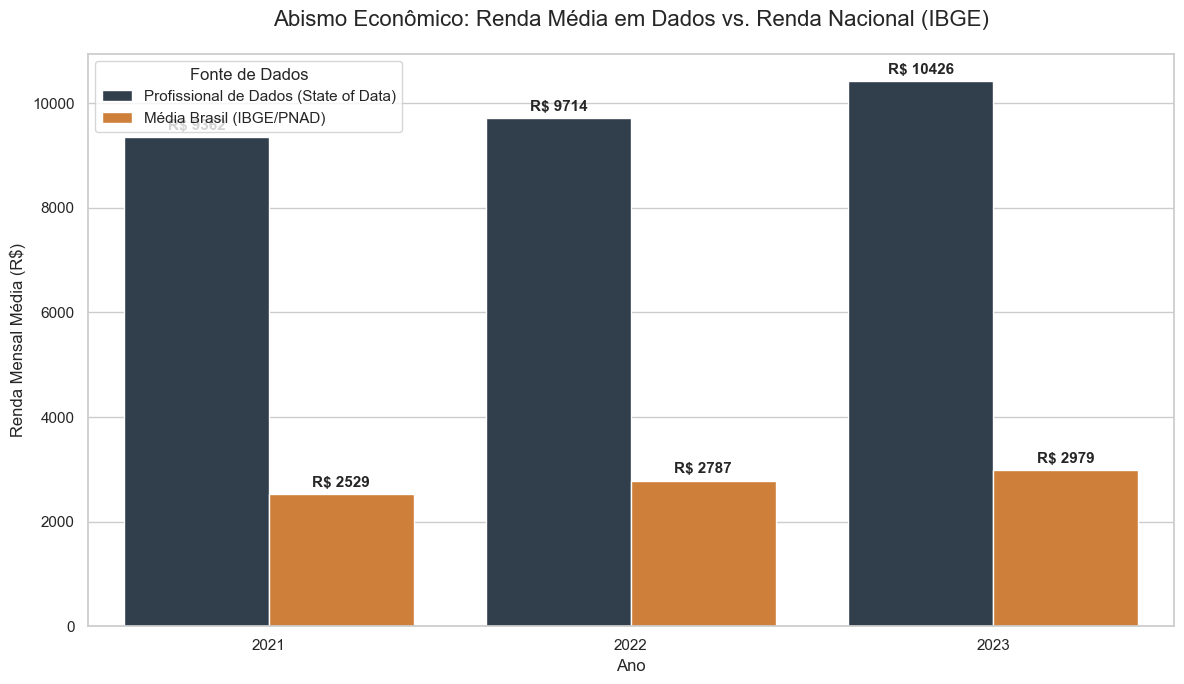

In [ ]:
import requests

# 1. Preparação dos Dados Internos (State of Data)
# Calculamos a média para ser comparável com a métrica padrão do IBGE
sod_anual = df_final.groupby('Ano')['Salario_Numerico'].mean().reset_index()
sod_anual['Fonte'] = 'Profissional de Dados (State of Data)'
sod_anual.rename(columns={'Salario_Numerico': 'Renda_Media'}, inplace=True)

# 2. Coleta de Dados Externos (API IBGE)
print("Consultando API do IBGE (SIDRA - PNAD Contínua)...")
url_ibge = "https://apisidra.ibge.gov.br/values/t/6390/n1/all/v/5932/p/2021,2022,2023"

try:
    response = requests.get(url_ibge)
    data_ibge = response.json()

    ibge_lista = []
    # O primeiro item é metadado, pulamos
    for item in data_ibge[1:]:
        ibge_lista.append({
            'Ano': int(item['D3C']),
            'Renda_Media': float(item['V']),
            'Fonte': 'Média Brasil (IBGE/PNAD)'
        })

    df_ibge = pd.DataFrame(ibge_lista)
    print("Dados do IBGE coletados com sucesso.")

except Exception as e:
    print(f"")
    # Valores oficiais para caso a API falhe na hora da apresentação
    df_ibge = pd.DataFrame([
        {'Ano': 2021, 'Renda_Media': 2529.00, 'Fonte': 'Média Brasil (IBGE/PNAD)'},
        {'Ano': 2022, 'Renda_Media': 2787.00, 'Fonte': 'Média Brasil (IBGE/PNAD)'},
        {'Ano': 2023, 'Renda_Media': 2979.00, 'Fonte': 'Média Brasil (IBGE/PNAD)'}
    ])

# 3. Consolidação e Visualização
# Limitamos o State of Data até 2023 para comparação justa (pois o dado oficial IBGE consolidado mais recente é 2023)
df_comparativo = pd.concat([sod_anual[sod_anual['Ano'] <= 2023], df_ibge], ignore_index=True)

plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=df_comparativo, x='Ano', y='Renda_Media', hue='Fonte',
                 palette={'Profissional de Dados (State of Data)': '#2c3e50',
                          'Média Brasil (IBGE/PNAD)': '#e67e22'})

# Rótulos
for container in ax.containers:
    ax.bar_label(container, fmt='R$ %.0f', padding=3, fontsize=11, fontweight='bold')

plt.title('Abismo Econômico: Renda Média em Dados vs. Renda Nacional (IBGE)', fontsize=16, pad=20)
plt.ylabel('Renda Mensal Média (R$)', fontsize=12)
plt.legend(title='Fonte de Dados')
plt.tight_layout()
plt.show()

### 7.1. Interpretação

O gráfico acima evidencia a disparidade estrutural entre a "economia tech" e a economia tradicional:

1.  **O "Gap" de 4x:** O profissional de dados ganha, em média, quase **quatro vezes mais** que a média nacional. Em 2023, enquanto o trabalhador brasileiro médio recebia R$ 2.979, a média na área de dados superava os R$ 10.000.

2.  **Resiliência na Crise:** Em 2021, auge dos efeitos econômicos da pandemia, a renda média brasileira atingiu uma mínima histórica (R$ 2.529). No mesmo período, a área de dados já operava em patamares elevados (acima de R$ 10k), mostrando que o setor foi blindado contra a recessão daquele ano.

## 8. Análise Comparativa Externa (Internacional): Comparação com Mercado Global
Nesta etapa, cruzamos os dados do State of Data Brazil com a pesquisa global Stack Overflow Developer Survey, filtrando apenas os respondentes do Brasil e do Mundo para os cargos de Dados. Realizamos a harmonização dos nomes dos cargos e a conversão monetária para permitir a comparação.

Carregando base Brasil...
Sucesso! Base Brasil carregada com 7201 registros filtrados.
Carregando base Global (Stack Overflow)...
Sucesso! Base Global carregada com 1168 registros.


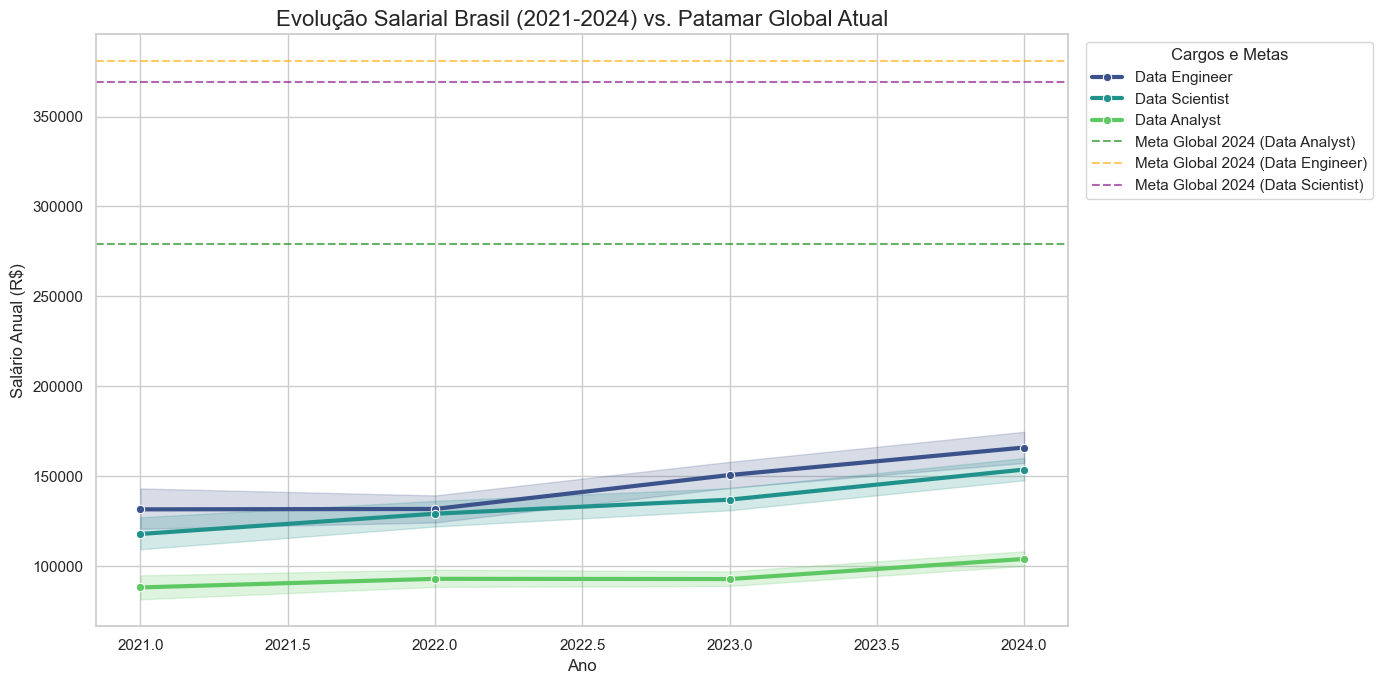

In [ ]:
# Configurações Visuais
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

# PREPARAÇÃO DA BASE BRASIL (STATE OF DATA)
print("Carregando base Brasil...")

try:
    df_br = pd.read_csv('base_state_of_data_FINAL.csv')
except FileNotFoundError:
    # Tenta carregar com encoding diferente se der erro
    df_br = pd.read_csv('base_state_of_data_FINAL.csv', encoding='latin1')

# Função para Padronizar Cargos (PT -> EN)
def mapear_cargo_br(texto):
    t = str(texto).lower()
    if 'cientista' in t: return 'Data Scientist'
    if 'analista de dados' in t: return 'Data Analyst'
    if 'engenheiro' in t and 'dados' in t: return 'Data Engineer'
    return None

df_br['Cargo_Unificado'] = df_br['Cargo'].apply(mapear_cargo_br)
df_br['Salario_Anual_BRL'] = df_br['Salario_Numerico'] * 13 # Inclui 13º
df_br['Origem'] = 'Brasil (State of Data)'
df_br['Ano'] = df_br['Ano'].fillna(2024).astype(int)

# Filtra apenas a tríade de dados (Analista, Engenheiro, Cientista)
cargos_foco = ['Data Analyst', 'Data Engineer', 'Data Scientist']
df_br_final = df_br[df_br['Cargo_Unificado'].isin(cargos_foco)].dropna(subset=['Salario_Anual_BRL'])

print(f"Sucesso! Base Brasil carregada com {len(df_br_final)} registros filtrados.")

# PREPARAÇÃO DA BASE GLOBAL (STACK OVERFLOW)
print("Carregando base Global (Stack Overflow)...")

arquivo_so = 'survey_results_public.csv'
tem_dados_globais = False
df_so_final = pd.DataFrame() # Cria vazio para não dar erro se falhar

if os.path.exists(arquivo_so):
    try:
        df_so = pd.read_csv(arquivo_so)

        # Padronização de Cargos Global
        def classificar_cargo_so(texto):
            t = str(texto).lower()
            if 'data scientist' in t: return 'Data Scientist'
            if 'data engineer' in t: return 'Data Engineer'
            if 'data analyst' in t or 'business analyst' in t: return 'Data Analyst'
            return None

        df_so['Cargo_Unificado'] = df_so['DevType'].apply(classificar_cargo_so)

        # Limpeza de nulos
        df_so = df_so.dropna(subset=['Cargo_Unificado', 'ConvertedCompYearly'])

        # Conversão Dólar -> Real e Limpeza de Outliers
        # Taxa de conversão estimada: 5.20
        df_so['Salario_Anual_BRL'] = df_so['ConvertedCompYearly'] * 5.20
        df_so['Origem'] = 'Mundo (Stack Overflow)'
        df_so['Ano'] = 2024

        # Remoção de Outliers Extremos (Método IQR para limpar salários irreais)
        Q1 = df_so['Salario_Anual_BRL'].quantile(0.25)
        Q3 = df_so['Salario_Anual_BRL'].quantile(0.75)
        limite_superior = Q3 + 1.5 * (Q3 - Q1)

        df_so_clean = df_so[df_so['Salario_Anual_BRL'] <= limite_superior]
        df_so_final = df_so_clean[df_so_clean['Cargo_Unificado'].isin(cargos_foco)]

        tem_dados_globais = True
        print(f"Sucesso! Base Global carregada com {len(df_so_final)} registros.")

    except Exception as e:
        print(f"Erro ao processar o CSV do Stack Overflow: {e}")
else:
    print(f"AVISO: O arquivo '{arquivo_so}' não foi encontrado na pasta.")
    print("O gráfico será gerado apenas com dados do Brasil.")

# --- 3. VISUALIZAÇÃO: A CORRIDA SALARIAL ---
plt.figure(figsize=(14, 7))

# 1. Linha do tempo: Evolução Brasil
sns.lineplot(data=df_br_final, x='Ano', y='Salario_Anual_BRL', hue='Cargo_Unificado',
             marker='o', linewidth=3, palette='viridis')

# 2. Linhas de Referência: Média Global Atual
if tem_dados_globais and not df_so_final.empty:
    cores_meta = {'Data Scientist': 'purple', 'Data Engineer': 'orange', 'Data Analyst': 'green'}

    # Loop para desenhar as linhas tracejadas de cada cargo
    for cargo in cargos_foco:
        dados_cargo = df_so_final[df_so_final['Cargo_Unificado'] == cargo]

        if not dados_cargo.empty:
            media_global = dados_cargo['Salario_Anual_BRL'].median()
            cor = cores_meta.get(cargo, 'grey')

            plt.axhline(y=media_global, linestyle='--', alpha=0.6, color=cor,
                        label=f'Meta Global 2024 ({cargo})')

plt.title('Evolução Salarial Brasil (2021-2024) vs. Patamar Global Atual', fontsize=16)
plt.ylabel('Salário Anual (R$)', fontsize=12)
plt.xlabel('Ano', fontsize=12)

# Ajuste da legenda para fora do gráfico
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', title="Cargos e Metas")
plt.tight_layout()
plt.show()

### 8.1. Interpretação: O Abismo Salarial Global

Ao cruzar os dados locais (*State of Data*) com o mercado global (*Stack Overflow*), a disparidade torna-se evidente:

1.  **A Hierarquia Mantém-se:** Tanto no Brasil (linhas sólidas) quanto no mundo (linhas tracejadas), a carreira de *Data Engineer* (Amarelo) permanece como a mais valorizada, seguida de perto por *Data Scientist*.

2.  **O "Gap" Cambial:** Existe um abismo entre o salário brasileiro e a média global convertida. A linha tracejada global está muito acima do topo da carreira no Brasil.

* **Conclusão:** Um profissional Sênior no Brasil ainda custa para o mercado global uma fração do que custaria um profissional médio nos EUA/Europa. Isso explica a alta atratividade do talento brasileiro para o trabalho remoto internacional.

## 9. Conclusão Final

A análise acima, fundamentada na integração de microdados da comunidade (*State of Data*) com indicadores macroeconômicos (*IBGE*) e globais (*Stack Overflow*), permite traçar um diagnóstico interessante da evolução do mercado de dados no Brasil entre 2021 e 2024:

1.  **De "Corrida do Ouro" a Estabilidade:**
    A fase de crescimento explosivo (2021-2022) encerrou-se. Embora a área continue sendo um **oásis econômico** pagando em média 4x mais que a renda nacional, os salários nominais estagnaram nos últimos dois anos. O ganho real (acima da inflação) está sendo afetado, indicando o amadurecimento do setor.

2.  **O Fosso da Senioridade (Barreira de Entrada):**
    Identificou-se um aumento drástico na desigualdade interna. O mercado tende a desvalorizar iniciantes (salários de Júniores estagnados), enquanto continuou premiando a alta especialização (Seniores). A experiência técnica tornou-se o ativo mais valioso, superando a formação acadêmica generalista.

3.  **Competitividade Global (Arbitragem Salarial):**
    O Brasil consolidou-se como um polo de talentos de alto nível e baixo custo em dólar. Mesmo os maiores salários locais (Cientistas de Dados Seniores) ainda estão muito abaixo da média global, incentivando o trabalho remoto internacional e a "fuga de cérebros" digital.

4.  **O Desafio Persistente da Diversidade:**
    Apesar do discurso corporativo, os dados mostram estagnação. A participação feminina permanece travada em aproximadamente 20% e o *gap* salarial persiste. A área de dados falhou, neste período, em tornar-se um ambiente mais inclusivo.

**Portanto:**
O mercado de dados brasileiro deixou de ser uma aposta de enriquecimento rápido para todos e tornou-se uma **carreira de elite técnica**, com altas recompensas para quem cruza a barreira da senioridade, mas com desafios crescentes de entrada e inclusão.